# Homework #5 Solutions
### Portfolio Theory and Risk Management I

## Imports

In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
sns.set(rc={'figure.figsize':(15, 10)})

## Data

In [511]:
factors = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name = 1)

factors = factors.set_index('Date')

factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0182,0.0175,-0.0169,0.0171,0.0755
1980-02-29,-0.0122,-0.0158,0.0061,0.0007,0.0270,0.0788
1980-03-31,-0.1290,-0.0692,-0.0101,0.0145,-0.0116,-0.0955
1980-04-30,0.0397,0.0105,0.0108,-0.0206,0.0027,-0.0043
1980-05-31,0.0526,0.0210,0.0038,0.0032,-0.0032,-0.0112


## 2 The Factors

**2.1:** Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare there univariate statistics.

In [512]:
def stats_dates(df, dates, annual_fac=12):
    stats_df = pd.DataFrame(data=None, index = ['Mean', 'Vol', 'Sharpe', 'VaR (.05)'])
    
    for d in dates:
        for col in df.columns:
            df_ = df.loc[d[0]:d[1], col]
            stats_df[col + ' ' + d[0] + '-' + d[1]] = [df_.mean()*annual_fac,
                                                       df_.std()*np.sqrt(annual_fac),
                                                       (df_.mean()/df_.std())*np.sqrt(annual_fac),
                                                       df_.quantile(.05)]
    
    return stats_df

def summary_stats(df, annual_fac=12):
    ss_df = (df.mean() * annual_fac).to_frame('Mean')
    ss_df['Vol'] = df.std() * np.sqrt(annual_fac)
    ss_df['Sharpe'] = ss_df['Mean'] / ss_df['Vol']
    
    return round(ss_df, 4)

Entire period:

In [513]:
summary_stats(factors)

,Mean,Vol,Sharpe
MKT,0.0873,0.1554,0.5619
SMB,0.0135,0.1010,0.1332
HML,0.0229,0.1061,0.2157
RMW,0.0425,0.0827,0.5135
CMA,0.0296,0.0686,0.4314
UMD,0.0646,0.1557,0.4150


**2.2a:** Does each factor have a positive risk premium (positive expected excess return)?

Over the entire period all of the factors have a positive risk premium.

Periods explored in HW 4:

In [514]:
stats_dates(factors, [['1926','1980'],['1981','2001'],['2002','2021']])

,MKT 1926-1980,SMB 1926-1980,HML 1926-1980,RMW 1926-1980,CMA 1926-1980,UMD 1926-1980,MKT 1981-2001,SMB 1981-2001,HML 1981-2001,RMW 1981-2001,CMA 1981-2001,UMD 1981-2001,MKT 2002-2021,SMB 2002-2021,HML 2002-2021,RMW 2002-2021,CMA 2002-2021,UMD 2002-2021
Mean,0.2029,0.0539,-0.1988,0.1086,-0.0976,0.3074,0.0773,0.0016,0.0636,0.0469,0.0534,0.1016,0.0921,0.0240,-0.0091,0.0344,0.0107,0.0129
Vol,0.2037,0.1088,0.1178,0.0729,0.0775,0.2346,0.1574,0.1097,0.1112,0.0922,0.0773,0.1451,0.1510,0.0907,0.0980,0.0720,0.0564,0.1606
Sharpe,0.9960,0.4952,-1.6874,1.4905,-1.2596,1.3101,0.4909,0.0145,0.5713,0.5086,0.6907,0.7004,0.6101,0.2649,-0.0930,0.4783,0.1901,0.0805
VaR (.05),-0.0829,-0.0493,-0.0727,-0.0186,-0.0409,-0.0797,-0.0645,-0.0434,-0.0418,-0.0301,-0.0306,-0.0610,-0.0772,-0.0393,-0.0399,-0.0256,-0.0232,-0.0737


2015-Present:

In [515]:
stats_dates(factors, [['2015','2021']])

,MKT 2015-2021,SMB 2015-2021,HML 2015-2021,RMW 2015-2021,CMA 2015-2021,UMD 2015-2021
Mean,0.1360,-0.0007,-0.0535,0.0240,-0.0252,0.0150
Vol,0.1519,0.1004,0.1206,0.0622,0.0612,0.1424
Sharpe,0.8953,-0.0074,-0.4437,0.3868,-0.4117,0.1055
VaR (.05),-0.0694,-0.0438,-0.0480,-0.0226,-0.0251,-0.0681


**2.2b:** How have the factors performed since the time of the case, (2015-present)?

RMW and UMD are the only factors apart from the market factor that have had positive risk premia. Value (HML) has notably underperformed.

**2.3:** Report the correlation matrix across the six factors.

In [516]:
factors.corr()

,MKT,SMB,HML,RMW,CMA,UMD
MKT,1.0000,0.2300,-0.2131,-0.2630,-0.3784,-0.1661
SMB,0.2300,1.0000,-0.0627,-0.4153,-0.0488,-0.0298
HML,-0.2131,-0.0627,1.0000,0.2419,0.6576,-0.2460
RMW,-0.2630,-0.4153,0.2419,1.0000,0.1212,0.0841
CMA,-0.3784,-0.0488,0.6576,0.1212,1.0000,-0.0214
UMD,-0.1661,-0.0298,-0.2460,0.0841,-0.0214,1.0000


**2.3a:** Does the construction method succeed in keeping correlations small?

Yes, correlations between factors are kept relatively small. The largest correlation is 0.6576, which is much higher than the other correlations.

**2.3b:** Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

Yes, HML is highly correlated to CMA (this is the 0.66 correlation). 

**2.4:** Report the tangency weights for a portfolio of these 6 factors.

In [517]:
def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))



    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    # For convenience, I'll wrap the solution back into a pandas.Series object.

    omega_tangency = pd.Series(weights, index=mu_tilde.index)

    return omega_tangency, mu_tilde, Sigma_adj



omega_tangency, mu_tilde, Sigma = compute_tangency(factors)

omega_tangency.to_frame('Tangency Weights')

,Tangency Weights
MKT,0.2078
SMB,0.0766
HML,-0.0549
RMW,0.2870
CMA,0.3875
UMD,0.0960


**2.4a:** Which factors seem most important? And Least?

CMA, RMW, and the MKT seem like the most important factors as they have the largest weights. SMB, HML, and UMD have lower weights so we could say that they seem less important. 

**2.4b:** Are the factors with low mean returns still useful?

In [518]:
summary_stats(factors)

,Mean,Vol,Sharpe
MKT,0.0873,0.1554,0.5619
SMB,0.0135,0.1010,0.1332
HML,0.0229,0.1061,0.2157
RMW,0.0425,0.0827,0.5135
CMA,0.0296,0.0686,0.4314
UMD,0.0646,0.1557,0.4150


Yes, CMA has one of the lower mean returns but the highest allocation.

**2.4c:** Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [519]:
omega_tangency2, mu_tilde2, Sigma2 = compute_tangency(factors[['MKT','SMB','HML','UMD']])

omega_tangency2.to_frame('Tangency Weights')

,Tangency Weights
MKT,0.3455
SMB,0.0041
HML,0.3532
UMD,0.2973


HML has the highest tangency weight once we remove CMA. This makes sense as CMA had the largest weight before, and is quite correlated to HML. 

SMB has a very small weight now.

We can conclude that the importance of these styles is very much based on correlation between the factors.

## 3 Testing Modern LPMs

In [520]:
portfolios = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name = 2)

portfolios = portfolios.set_index('Date')

portfolios.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0050,0.0283,0.0084,0.1024,-0.0143,0.0999,0.0354,0.0352,0.0048,0.0032,...,0.0159,0.0876,0.0463,-0.0119,0.0458,-0.0279,0.0258,0.0751,0.0299,0.0663
1980-02-29,0.0111,-0.0610,-0.0966,-0.0319,-0.0569,-0.0314,-0.0527,-0.0788,-0.0556,-0.0140,...,-0.0079,-0.0535,-0.0339,-0.0636,-0.0638,-0.0855,-0.0960,-0.0314,-0.0275,-0.0266
1980-03-31,-0.2244,-0.1116,-0.0167,-0.1464,-0.0192,-0.1281,-0.0817,-0.1278,-0.0565,-0.0664,...,-0.0821,-0.1511,-0.1106,-0.0913,-0.1443,-0.0563,-0.0883,-0.2441,-0.1243,-0.1733
1980-04-30,0.0451,0.0766,0.0232,0.0305,0.0831,-0.0521,0.0775,0.0182,0.0304,0.0113,...,0.0419,-0.0097,-0.0300,0.0341,0.0522,0.0729,0.0532,0.0997,0.0448,0.0771
1980-05-31,0.0637,0.0792,0.0457,0.0895,0.0814,0.0512,0.0324,0.0876,0.0560,0.0064,...,0.0565,0.1060,0.1147,0.0872,0.1127,0.0577,0.0557,0.1040,0.0839,0.0681


In [521]:
CAPM =  ['MKT']
FF_3F = ['MKT','SMB','HML']
FF_5F = ['MKT','SMB','HML','RMW','CMA']
AQR = ['MKT','HML','RMW','UMD']

**3.1:** Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

In [522]:
def ts_test(df, factor_df, factors, test, annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = [test + r' $\alpha$', test + r' $R^{2}$'])
    
    for port in df.columns:
        y = df[port]
        X = sm.add_constant(factor_df[factors])
        model = sm.OLS(y, X).fit()
        res.loc[port] = [model.params[0] * annualization, model.rsquared]
    
    return res

**3.1a:** For each regression, report the estimated $\alpha$ and $R^{2}$.

In [523]:
AQR_test = ts_test(portfolios, factors, AQR, 'AQR')

AQR_test

,AQR $\alpha$,AQR $R^{2}$
Agric,0.0062,0.334
Food,0.0115,0.4812
Soda,0.0197,0.3148
Beer,0.0232,0.4277
Smoke,0.0397,0.2663
Toys,-0.0155,0.5042
Fun,0.0351,0.6096
Books,-0.027,0.6878
Hshld,-0.0007,0.5797
Clths,0.0035,0.6163


**3.1b:** Calculate the mean-absolute-error of the estimated alphas.

In [524]:
print('AQR MAE: ' + str(round(AQR_test[r'AQR $\alpha$'].abs().mean(), 4)))

AQR MAE: 0.0242


**3.2:** Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [525]:
factor_tests = ts_test(portfolios, factors, CAPM, 'CAPM').join(ts_test(portfolios, factors, FF_3F, 'Fama-French 3F'))\
                                                         .join(ts_test(portfolios, factors, FF_5F, 'Fama-French 5F'))

factors_MAE = factor_tests[[r'CAPM $\alpha$',
                            r'Fama-French 3F $\alpha$',
                            r'Fama-French 5F $\alpha$']].abs().mean().to_frame('MAE')

factors_MAE.index = ['CAPM','Fama-French 3F','Fama-French 5F']
factors_MAE.loc['AQR'] = AQR_test[r'AQR $\alpha$'].abs().mean()
factors_MAE

,MAE
CAPM,0.0220
Fama-French 3F,0.0262
Fama-French 5F,0.0332
AQR,0.0242


CAPM fits the best as it has the lowest MAE. 

**3.3**: Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

The market factor seems very important for pricing as all models include it and the CAPM performs the best. I think Fama and French should consider using the momentum factor as AQR uses it and their model performs better in terms of MAE. 

**3.4:** This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [526]:
factors_r2 = factor_tests[[r'CAPM $R^{2}$',
                            r'Fama-French 3F $R^{2}$',
                            r'Fama-French 5F $R^{2}$']].mean().to_frame(r'$R^{2}$')

factors_r2.index = ['CAPM','Fama-French 3F','Fama-French 5F']
factors_r2.loc['AQR'] = AQR_test[r'AQR $R^{2}$'].mean()
factors_r2

,$R^{2}$
CAPM,0.5283
Fama-French 3F,0.5725
Fama-French 5F,0.5986
AQR,0.5780


These models do not lead to high time-series $R^{2}$ stats. Thus, they would not be good in a Linear Factor Decomposition of the assets.

## 4 Extensions

In [527]:
def ts_betas(df, factor_df, factors, intercept=False):
    if intercept == True:
        res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha'])
        res[factors] = None
    else:
        res = pd.DataFrame(data = None, index = df.columns, columns = factors)
    
    for port in df.columns:
        y = df[port]
        if intercept == True:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        res.loc[port] = model.params
    
    return res

def cross_section(df, factor_df, factors, ts_int=True, annualization=12):
    betas = ts_betas(df, factor_df, factors, intercept=ts_int)
    res = pd.DataFrame(data = None, index = betas.index, columns = factors)
    res['Predicted'] = None
    res['Actual'] = None
    
    for port in res.index:
        res.loc[port, factors] = betas.loc[port]
        prem = (betas.loc[port] * factor_df[factors]).sum(axis=1).mean() * annualization
        res.loc[port,['Predicted','Actual']] = prem, df[port].mean() * annualization
    
    return res

def cross_premia(df_cs, factors):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    return sm.OLS(y,X).fit().params.to_frame('CS Premia')

def cross_premia_mae(df_cs, factors, model):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    print(model + ' MAE: ' + str(round(sm.OLS(y,X).fit().resid.abs().mean(), 4)))
    return

In [528]:
CAPM_cs = cross_section(portfolios, factors, CAPM, ts_int=True)
FF_3F_cs = cross_section(portfolios, factors, FF_3F, ts_int=True)
FF_5F_cs = cross_section(portfolios, factors, FF_5F, ts_int=True)
AQR_cs = cross_section(portfolios, factors, AQR, ts_int=True)

AQR_cs.head()

,MKT,HML,RMW,UMD,Predicted,Actual
Agric,0.8288,0.1076,0.0073,0.0733,0.0799,0.086
Food,0.6996,0.1496,0.5527,0.0322,0.0901,0.1015
Soda,0.8087,0.1911,0.4982,-0.1011,0.0896,0.1093
Beer,0.7401,0.0054,0.6111,0.0737,0.0955,0.1187
Smoke,0.738,0.1426,0.7092,-0.0537,0.0943,0.134


**4.1a:** Report the time-series premia of the factors (just their sample averages) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [529]:
(factors.mean()*12).to_frame('TS Premia')

,TS Premia
MKT,0.0873
SMB,0.0135
HML,0.0229
RMW,0.0425
CMA,0.0296
UMD,0.0646


Fama-French 3 Factor Premia:

In [530]:
cross_premia(FF_3F_cs, FF_3F)

,CS Premia
MKT,0.1046
SMB,-0.0641
HML,-0.0235


Fama-French 5 Factor Premia:

In [531]:
cross_premia(FF_5F_cs, FF_5F)

,CS Premia
MKT,0.0977
SMB,-0.0582
HML,-0.0448
RMW,0.0417
CMA,-0.0292


AQR Premia:

In [532]:
cross_premia(AQR_cs, AQR)

,CS Premia
MKT,0.0871
HML,-0.0535
RMW,0.0499
UMD,0.0178


The MKT and RMW factors are similar to the sample averages, but the other cross-sectionally estimated premia vary quite a bit.

**4.1b:** Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [533]:
cross_premia_mae(CAPM_cs, CAPM, 'CAPM')

CAPM MAE: 0.022


In [534]:
cross_premia_mae(FF_3F_cs, FF_3F, 'FF 3 Factor')

FF 3 Factor MAE: 0.0159


In [535]:
cross_premia_mae(FF_5F_cs, FF_5F, 'FF 5 Factor')

FF 5 Factor MAE: 0.0127


In [536]:
cross_premia_mae(AQR_cs, AQR, 'AQR')

AQR MAE: 0.0164


**4.2:**

In [537]:
def OOS_prediction(df, factor_df, factors, window):
    res = pd.DataFrame(data = None, index = df.columns, columns = [r'$R^{2}$'])
    exp_means = factor_df[factors].expanding().mean()
    factors2 = factors.copy()
    factors2.append('const')
    factor_df2 = factor_df.copy()
    factor_df2['const'] = 1
    for port in df.columns:
        model = RollingOLS(df[port], factor_df2[factors2], window = window, min_nobs = window).fit()
        port_betas = model.params.dropna()
        r_hat = (port_betas[factors] * exp_means.loc[port_betas.index]).sum(axis=1).shift(1).dropna()
        exp_means_predict = df[port].expanding().mean().shift(1).loc[r_hat.index]
        res.loc[port] = 1 - ((r_hat - df.loc[r_hat.index, port])**2).sum()\
                            / ((exp_means_predict - df.loc[r_hat.index, port])**2).sum()
    
    res[r'$R^{2}$'] = res[r'$R^{2}$'].astype(float)
    return res

**4.2a:** Report the OOS r-squared for each of the n security forecasts.

In [538]:
port_R2 = OOS_prediction(portfolios, factors, AQR, 60)

port_R2

,$R^{2}$
Agric,-5.0601e-05
Food,-7.8223e-03
Soda,-5.1195e-03
Beer,-4.2098e-04
Smoke,-2.3391e-03
Toys,1.2511e-03
Fun,-5.2620e-03
Books,-1.1106e-03
Hshld,6.6727e-04
Clths,-3.4415e-03


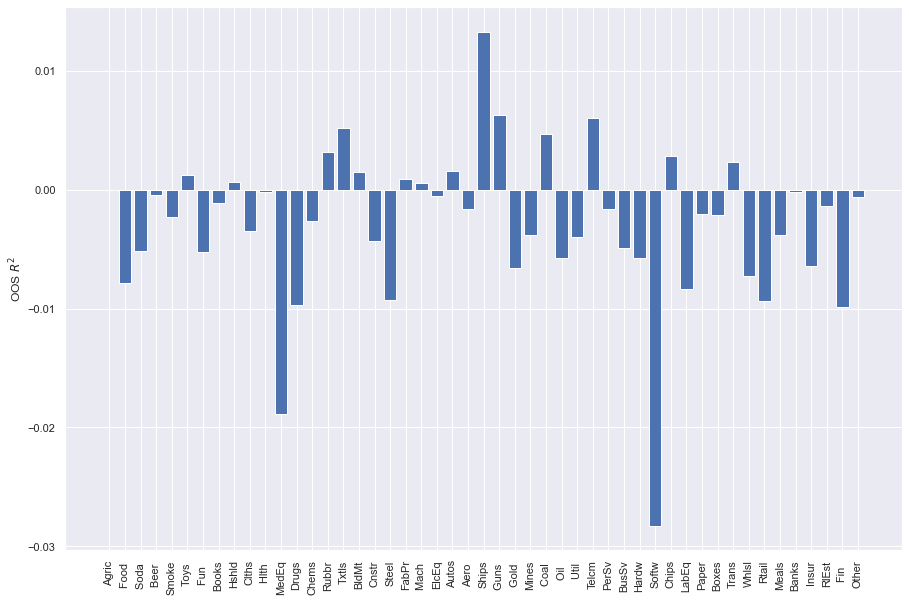

In [539]:
plt.bar(port_R2.index, port_R2[r'$R^{2}$'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS $R^{2}$')

plt.show()

In [540]:
port_R2.describe()

,$R^{2}$
count,49.0000
mean,-0.0027
std,0.0065
min,-0.0283
25%,-0.0057
50%,-0.0020
75%,0.0007
max,0.0133


**4.2b:** Does the LPM do a good job of forecasting monthly returns? For which asset does it perform best? And worst?

The LPM does a very poor job forecasting monthly returns. It performs best for ships and worst for software. 

In [541]:
port_R2.sort_values(r'$R^{2}$')

,$R^{2}$
Softw,-2.8280e-02
MedEq,-1.8888e-02
Fin,-9.8372e-03
Drugs,-9.6659e-03
Rtail,-9.4027e-03
Steel,-9.2750e-03
LabEq,-8.3269e-03
Food,-7.8223e-03
Whlsl,-7.2254e-03
Gold,-6.5998e-03


**4.2c:** Re-do the exercise using a window of 36 months. And 96 months. Do either of these windows work better?

In [542]:
port_R2_36 = OOS_prediction(portfolios, factors, AQR, 36)

port_R2_36

,$R^{2}$
Agric,-0.0035
Food,-0.0059
Soda,-0.0093
Beer,-0.0026
Smoke,0.0021
Toys,0.0028
Fun,-0.0052
Books,0.0004
Hshld,0.0010
Clths,-0.0036


In [543]:
port_R2_36.describe()

,$R^{2}$
count,49.0000
mean,-0.0017
std,0.0055
min,-0.0167
25%,-0.0048
50%,-0.0008
75%,0.0020
max,0.0098


In [544]:
port_R2_96 = OOS_prediction(portfolios, factors, AQR, 96)

port_R2_96

,$R^{2}$
Agric,2.1116e-04
Food,-5.5708e-03
Soda,-4.1336e-03
Beer,5.4021e-04
Smoke,-8.0904e-03
Toys,3.9795e-03
Fun,-6.4327e-04
Books,3.2819e-04
Hshld,2.0106e-03
Clths,-1.6945e-04


In [545]:
port_R2_96.describe()

,$R^{2}$
count,49.0000
mean,-0.0019
std,0.0064
min,-0.0260
25%,-0.0041
50%,-0.0006
75%,0.0012
max,0.0099


No, neither of these windows perform much better. OOS $R^{2}$ is still about zero.

**4.2d:**

In [546]:
port_R2_CAPM = OOS_prediction(portfolios, factors, CAPM, 60)

port_R2_CAPM

,$R^{2}$
Agric,7.0049e-04
Food,-7.0360e-03
Soda,-2.4682e-03
Beer,-9.4677e-03
Smoke,-7.3004e-03
Toys,3.7868e-03
Fun,1.9277e-03
Books,5.0963e-03
Hshld,-1.6206e-03
Clths,-1.6915e-03


In [547]:
port_R2_CAPM.describe()

,$R^{2}$
count,49.0000
mean,0.0003
std,0.0040
min,-0.0098
25%,-0.0018
50%,0.0008
75%,0.0028
max,0.0071


In [548]:
port_R2_FF5 = OOS_prediction(portfolios, factors, FF_5F, 60)

port_R2_FF5

,$R^{2}$
Agric,3.0139e-03
Food,-1.1632e-02
Soda,-1.6798e-02
Beer,-1.1118e-02
Smoke,-6.3167e-03
Toys,-1.7601e-03
Fun,-8.8799e-05
Books,-1.1703e-04
Hshld,-5.9411e-03
Clths,-9.1770e-04


In [549]:
port_R2_FF5.describe()

,$R^{2}$
count,49.0000
mean,-0.0031
std,0.0074
min,-0.0219
25%,-0.0076
50%,-0.0018
75%,0.0021
max,0.0123


CAPM performs best out of all the models, but it still not valuable for prediction.